
# Analisis Udara Atas


Analisis udara atas adalah pokok dari banyak masalah analisis sinoptik dan mesoscale. Dalam tutorial ini kita akan mengumpulkan data balon cuaca, memplotnya, melakukan serangkaian perhitungan termodinamika, dan merangkum hasilnya. Untuk mempelajari lebih lanjut tentang diagram Skew-T dan penggunaannya dalam analisis dan prakiraan cuaca, lihat panduan layanan cuaca udara ini .


In [ ]:
%matplotlib inline

In [ ]:
pip install metpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/TUBES_MOCU/Radiosonde'

 22092021_00UTC.txt   25092021_00UTC.txt   28092021_00UTC.txt
 23092021_00UTC.txt   26092021_00UTC.txt  'Script Skew -T(Gcolab).ipynb'
 24092021_00UTC.txt   27092021_00UTC.txt


# 22 September 2021 00Z

In [ ]:
#Pilih Data yang aka digunakan dalam diagram Skew-T
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']


#Baca Fie data yang tersedia
df = pd.read_fwf('drive/MyDrive/TUBES_MOCU/Radiosonde/22092021_00UTC.txt',skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Menghilangkan Nilai NaN dalam data T,Td, dan Angin
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [ ]:
#Menjadikan data dari contoh dataset ke dalam variabel individu dan menentukan bearannya

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

Thermodynamic Calculations
--------------------------

Often times we will want to calculate some thermodynamic parameters of a
sounding. The MetPy calc module has many such calculations already implemented!

* **Lifting Condensation Level (LCL)** - The level at which an air parcel's
  relative humidity becomes 100% when lifted along a dry adiabatic path.
* **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
  at the surface temperature/pressure and rising dry adiabatically until
  reaching the LCL, then rising moist adiabatially.



In [ ]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')


998.7582853192407 hectopascal 23.481624987039368 degree_Celsius


Ploting Dasar Skew-T
---------------------

Diagram Skew-T (log-P) adalah cara standar untuk melihat data radiosonde. Sumbu y adalah ketinggian dalam koordinat tekanan dan sumbu x adalah suhu. Koordinat y diplot pada skala logaritmik dan sistem koordinat x miring. Penjelasan tentang interpretasi skew-T berada di luar cakupan tutorial ini, tetapi di sini kami akan memplot satu yang dapat digunakan untuk analisis atau publikasi.

Skew-T paling dasar dapat diplot hanya dengan lima baris Python. Garis-garis ini melakukan tugas-tugas berikut:

1. Buat Figure objek dan atur ukuran gambar.

2. Buat SkewT objek

3. Plot tekanan dan suhu (perhatikan bahwa tekanan, variabel bebas, adalah yang pertama meskipun diplot pada sumbu y).

4. Plot tekanan dan suhu titik embun.

5. Plotlah wind barb pada tekanan yang sesuai dengan menggunakan komponen angin u dan v.



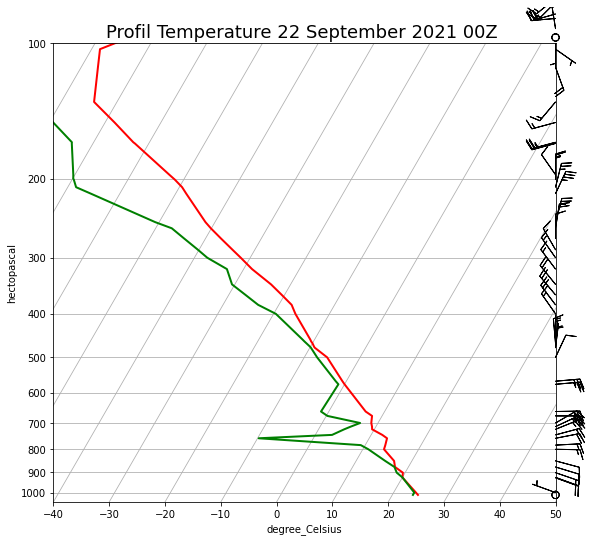

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.title('Profil Temperature 22 September 2021 00Z ', fontsize ='18')
plt.savefig('22sep1.png', dpi=None)
plt.show()

Plot Skew-T Tambahan
------------------------

Garis fidusia yang menunjukkan adiabat kering, adiabat lembab, dan rasio pencampuran berguna saat melakukan analisis lebih lanjut pada diagram Skew-T. Seringkali isoterm 0C ditekankan dan area CAPE dan CIN diarsir.



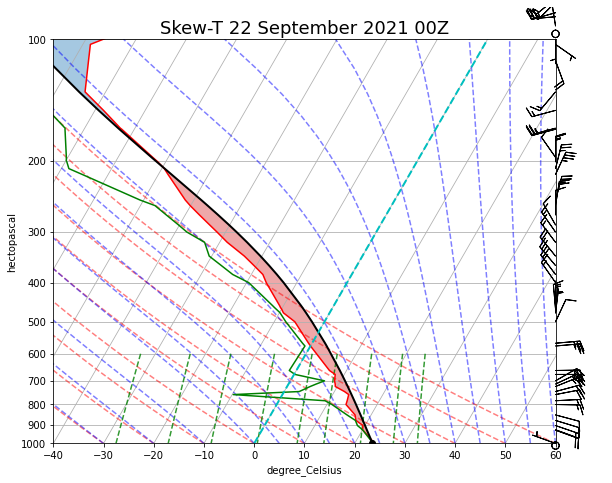

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.title('Skew-T 22 September 2021 00Z', fontsize ='18')
plt.savefig('22sep.png', dpi=None)
plt.show()

arsiran merah cape, arsiran biru cin.

Adding a Hodograph
------------------

A hodograph is a polar representation of the wind profile measured by the rawinsonde.
Winds at different levels are plotted as vectors with their tails at the origin, the angle
from the vertical axes representing the direction, and the length representing the speed.
The line plotted on the hodograph is a line connecting the tips of these vectors,
which are not drawn.



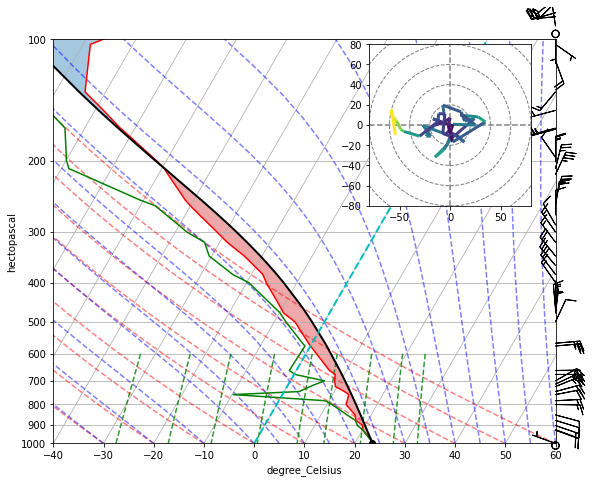

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wind_speed)  # Plot a line colored by wind speed

# Show the plot
plt.savefig('22sep2.png', dpi=None)
plt.show()

# 23 September 2021 12Z

In [ ]:
#Pilih Data yang aka digunakan dalam diagram Skew-T
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']


#Baca Fie data yang tersedia
df = pd.read_fwf('drive/MyDrive/TUBES_MOCU/Radiosonde/23092021_00UTC.txt',skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Menghilangkan Nilai NaN dalam data T,Td, dan Angin
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [ ]:
#Menjadikan data dari contoh dataset ke dalam variabel individu dan menentukan bearannya

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

Thermodynamic Calculations
--------------------------

Often times we will want to calculate some thermodynamic parameters of a
sounding. The MetPy calc module has many such calculations already implemented!

* **Lifting Condensation Level (LCL)** - The level at which an air parcel's
  relative humidity becomes 100% when lifted along a dry adiabatic path.
* **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
  at the surface temperature/pressure and rising dry adiabatically until
  reaching the LCL, then rising moist adiabatially.



In [ ]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')


991.4902715336693 hectopascal 23.260938523003745 degree_Celsius


Ploting Dasar Skew-T
---------------------

Diagram Skew-T (log-P) adalah cara standar untuk melihat data radiosonde. Sumbu y adalah ketinggian dalam koordinat tekanan dan sumbu x adalah suhu. Koordinat y diplot pada skala logaritmik dan sistem koordinat x miring. Penjelasan tentang interpretasi skew-T berada di luar cakupan tutorial ini, tetapi di sini kami akan memplot satu yang dapat digunakan untuk analisis atau publikasi.

Skew-T paling dasar dapat diplot hanya dengan lima baris Python. Garis-garis ini melakukan tugas-tugas berikut:

1. Buat Figure objek dan atur ukuran gambar.

2. Buat SkewT objek

3. Plot tekanan dan suhu (perhatikan bahwa tekanan, variabel bebas, adalah yang pertama meskipun diplot pada sumbu y).

4. Plot tekanan dan suhu titik embun.

5. Plotlah wind barb pada tekanan yang sesuai dengan menggunakan komponen angin u dan v.



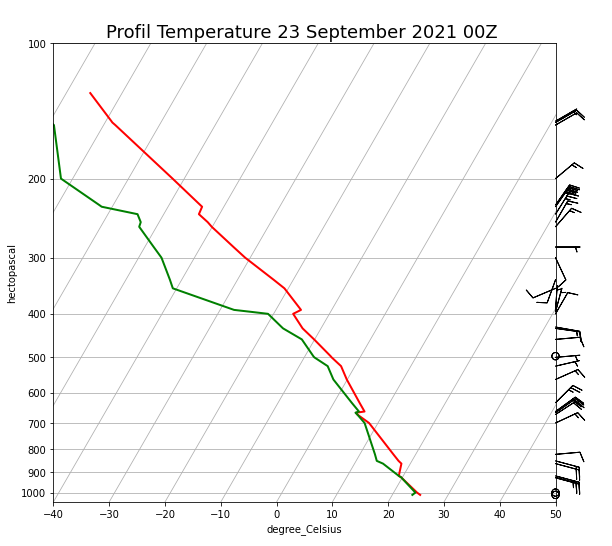

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.title('Profil Temperature 23 September 2021 00Z ', fontsize ='18')
plt.savefig('Juanda.png', dpi=None)
plt.show()

Plot Skew-T Tambahan
------------------------

Garis fidusia yang menunjukkan adiabat kering, adiabat lembab, dan rasio pencampuran berguna saat melakukan analisis lebih lanjut pada diagram Skew-T. Seringkali isoterm 0C ditekankan dan area CAPE dan CIN diarsir.



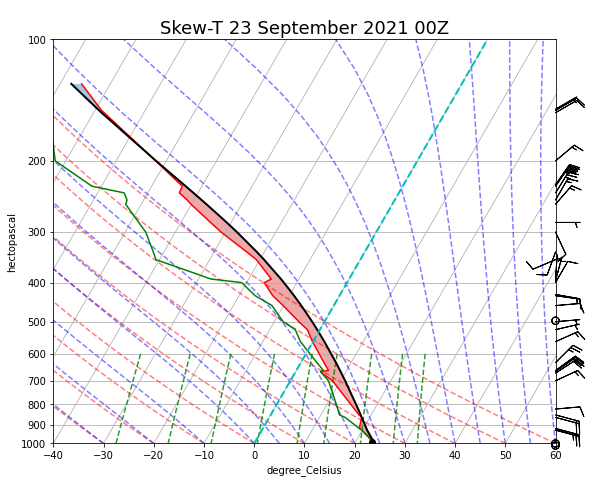

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.title('Skew-T 23 September 2021 00Z', fontsize ='18')
plt.savefig('Juanda.png', dpi=None)
plt.show()

arsiran merah cape, arsiran biru cin.

Adding a Hodograph
------------------

A hodograph is a polar representation of the wind profile measured by the rawinsonde.
Winds at different levels are plotted as vectors with their tails at the origin, the angle
from the vertical axes representing the direction, and the length representing the speed.
The line plotted on the hodograph is a line connecting the tips of these vectors,
which are not drawn.



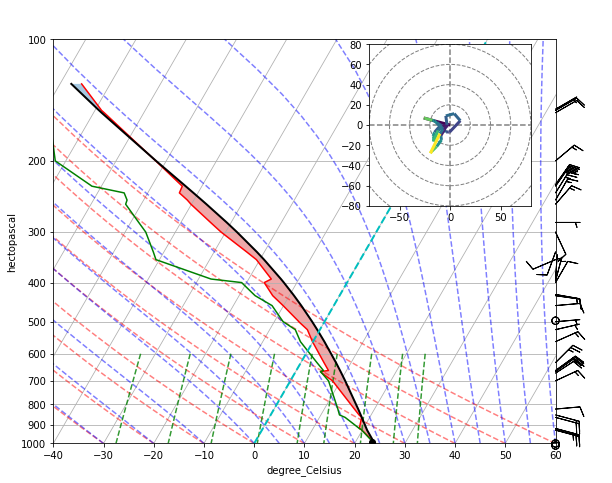

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wind_speed)  # Plot a line colored by wind speed

# Show the plot
plt.savefig('Juanda.png', dpi=None)
plt.show()

# 24 September 2021 00Z

In [ ]:
#Pilih Data yang aka digunakan dalam diagram Skew-T
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']


#Baca Fie data yang tersedia
df = pd.read_fwf('drive/MyDrive/TUBES_MOCU/Radiosonde/24092021_00UTC.txt',skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Menghilangkan Nilai NaN dalam data T,Td, dan Angin
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [ ]:
#Menjadikan data dari contoh dataset ke dalam variabel individu dan menentukan bearannya

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

Thermodynamic Calculations
--------------------------

Often times we will want to calculate some thermodynamic parameters of a
sounding. The MetPy calc module has many such calculations already implemented!

* **Lifting Condensation Level (LCL)** - The level at which an air parcel's
  relative humidity becomes 100% when lifted along a dry adiabatic path.
* **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
  at the surface temperature/pressure and rising dry adiabatically until
  reaching the LCL, then rising moist adiabatially.



In [ ]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')


997.3175543688349 hectopascal 23.956805327251914 degree_Celsius


Ploting Dasar Skew-T
---------------------

Diagram Skew-T (log-P) adalah cara standar untuk melihat data radiosonde. Sumbu y adalah ketinggian dalam koordinat tekanan dan sumbu x adalah suhu. Koordinat y diplot pada skala logaritmik dan sistem koordinat x miring. Penjelasan tentang interpretasi skew-T berada di luar cakupan tutorial ini, tetapi di sini kami akan memplot satu yang dapat digunakan untuk analisis atau publikasi.

Skew-T paling dasar dapat diplot hanya dengan lima baris Python. Garis-garis ini melakukan tugas-tugas berikut:

1. Buat Figure objek dan atur ukuran gambar.

2. Buat SkewT objek

3. Plot tekanan dan suhu (perhatikan bahwa tekanan, variabel bebas, adalah yang pertama meskipun diplot pada sumbu y).

4. Plot tekanan dan suhu titik embun.

5. Plotlah wind barb pada tekanan yang sesuai dengan menggunakan komponen angin u dan v.



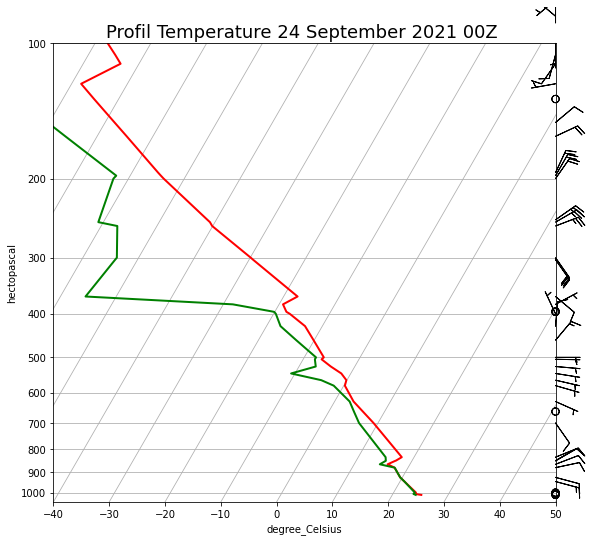

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.title('Profil Temperature 24 September 2021 00Z ', fontsize ='18')
plt.savefig('Juanda1.png', dpi=None)
plt.show()

Plot Skew-T Tambahan
------------------------

Garis fidusia yang menunjukkan adiabat kering, adiabat lembab, dan rasio pencampuran berguna saat melakukan analisis lebih lanjut pada diagram Skew-T. Seringkali isoterm 0C ditekankan dan area CAPE dan CIN diarsir.



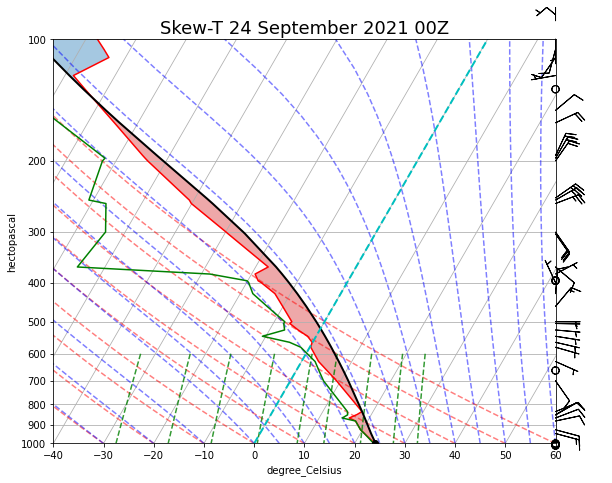

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.title('Skew-T 24 September 2021 00Z', fontsize ='18')
plt.savefig('Juanda.png', dpi=None)
plt.show()

arsiran merah cape, arsiran biru cin.

Adding a Hodograph
------------------

A hodograph is a polar representation of the wind profile measured by the rawinsonde.
Winds at different levels are plotted as vectors with their tails at the origin, the angle
from the vertical axes representing the direction, and the length representing the speed.
The line plotted on the hodograph is a line connecting the tips of these vectors,
which are not drawn.



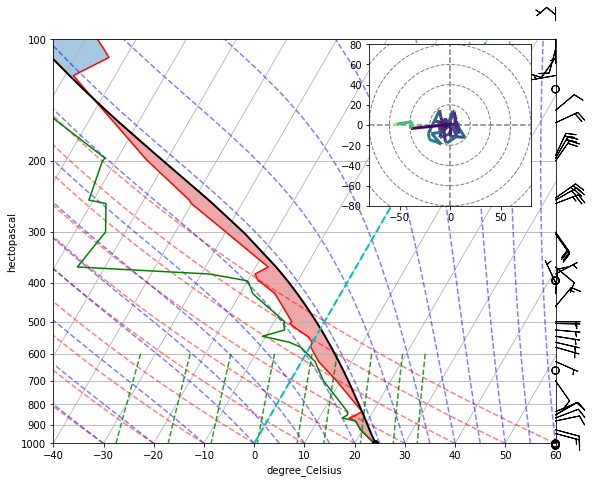

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wind_speed)  # Plot a line colored by wind speed

# Show the plot
plt.savefig('Juanda.png', dpi=None)
plt.show()

# 25 September 2021 00Z

In [ ]:
#Pilih Data yang aka digunakan dalam diagram Skew-T
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']


#Baca Fie data yang tersedia
df = pd.read_fwf('drive/MyDrive/TUBES_MOCU/Radiosonde/25092021_00UTC.txt',skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Menghilangkan Nilai NaN dalam data T,Td, dan Angin
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [ ]:
#Menjadikan data dari contoh dataset ke dalam variabel individu dan menentukan bearannya

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

Thermodynamic Calculations
--------------------------

Often times we will want to calculate some thermodynamic parameters of a
sounding. The MetPy calc module has many such calculations already implemented!

* **Lifting Condensation Level (LCL)** - The level at which an air parcel's
  relative humidity becomes 100% when lifted along a dry adiabatic path.
* **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
  at the surface temperature/pressure and rising dry adiabatically until
  reaching the LCL, then rising moist adiabatially.



In [ ]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')


482.1741825061693 hectopascal -30.87498277273545 degree_Celsius


Ploting Dasar Skew-T
---------------------

Diagram Skew-T (log-P) adalah cara standar untuk melihat data radiosonde. Sumbu y adalah ketinggian dalam koordinat tekanan dan sumbu x adalah suhu. Koordinat y diplot pada skala logaritmik dan sistem koordinat x miring. Penjelasan tentang interpretasi skew-T berada di luar cakupan tutorial ini, tetapi di sini kami akan memplot satu yang dapat digunakan untuk analisis atau publikasi.

Skew-T paling dasar dapat diplot hanya dengan lima baris Python. Garis-garis ini melakukan tugas-tugas berikut:

1. Buat Figure objek dan atur ukuran gambar.

2. Buat SkewT objek

3. Plot tekanan dan suhu (perhatikan bahwa tekanan, variabel bebas, adalah yang pertama meskipun diplot pada sumbu y).

4. Plot tekanan dan suhu titik embun.

5. Plotlah wind barb pada tekanan yang sesuai dengan menggunakan komponen angin u dan v.



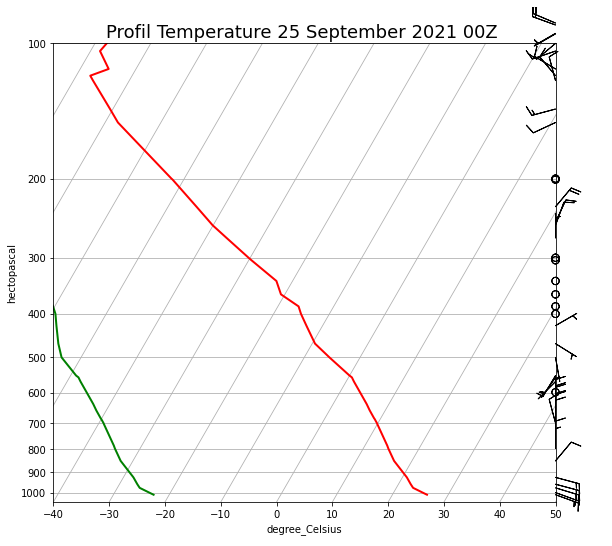

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.title('Profil Temperature 25 September 2021 00Z ', fontsize ='18')
plt.savefig('Juanda1.png', dpi=None)
plt.show()

Plot Skew-T Tambahan
------------------------

Garis fidusia yang menunjukkan adiabat kering, adiabat lembab, dan rasio pencampuran berguna saat melakukan analisis lebih lanjut pada diagram Skew-T. Seringkali isoterm 0C ditekankan dan area CAPE dan CIN diarsir.



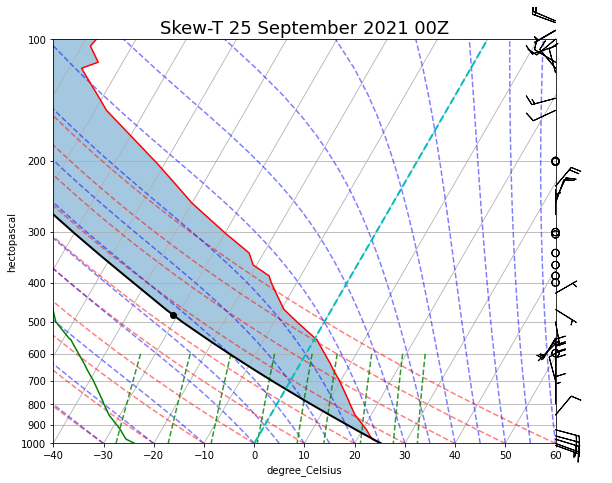

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.title('Skew-T 25 September 2021 00Z', fontsize ='18')
plt.savefig('Juanda.png', dpi=None)
plt.show()

arsiran merah cape, arsiran biru cin.

Adding a Hodograph
------------------

A hodograph is a polar representation of the wind profile measured by the rawinsonde.
Winds at different levels are plotted as vectors with their tails at the origin, the angle
from the vertical axes representing the direction, and the length representing the speed.
The line plotted on the hodograph is a line connecting the tips of these vectors,
which are not drawn.



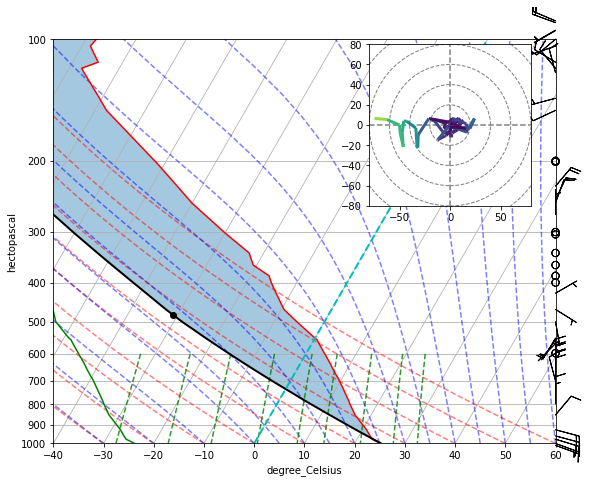

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wind_speed)  # Plot a line colored by wind speed

# Show the plot
plt.savefig('Juanda.png', dpi=None)
plt.show()

# 26 September 2021 00Z

In [ ]:
#Pilih Data yang aka digunakan dalam diagram Skew-T
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']


#Baca Fie data yang tersedia
df = pd.read_fwf('drive/MyDrive/TUBES_MOCU/Radiosonde/26092021_00UTC.txt',skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Menghilangkan Nilai NaN dalam data T,Td, dan Angin
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [ ]:
#Menjadikan data dari contoh dataset ke dalam variabel individu dan menentukan bearannya

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

[teks link](https://)Thermodynamic Calculations
--------------------------

Often times we will want to calculate some thermodynamic parameters of a
sounding. The MetPy calc module has many such calculations already implemented!

* **Lifting Condensation Level (LCL)** - The level at which an air parcel's
  relative humidity becomes 100% when lifted along a dry adiabatic path.
* **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
  at the surface temperature/pressure and rising dry adiabatically until
  reaching the LCL, then rising moist adiabatially.



In [ ]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')


974.7485844570281 hectopascal 22.697256075368273 degree_Celsius


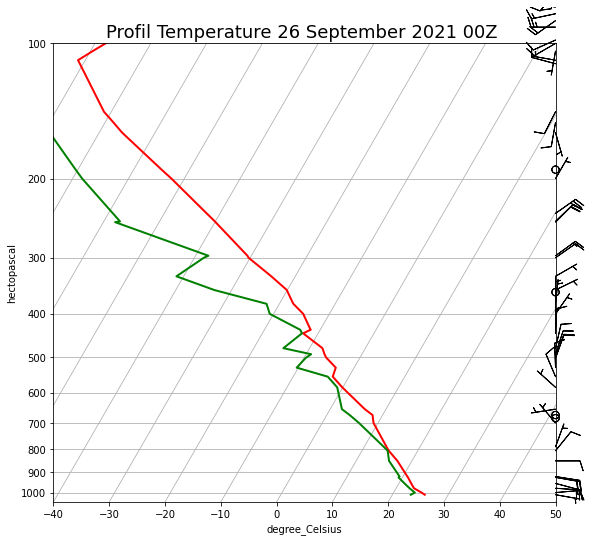

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.title('Profil Temperature 26 September 2021 00Z ', fontsize ='18')
plt.savefig('Juanda1.png', dpi=None)
plt.show()

Plot Skew-T Tambahan
------------------------

Garis fidusia yang menunjukkan adiabat kering, adiabat lembab, dan rasio pencampuran berguna saat melakukan analisis lebih lanjut pada diagram Skew-T. Seringkali isoterm 0C ditekankan dan area CAPE dan CIN diarsir.



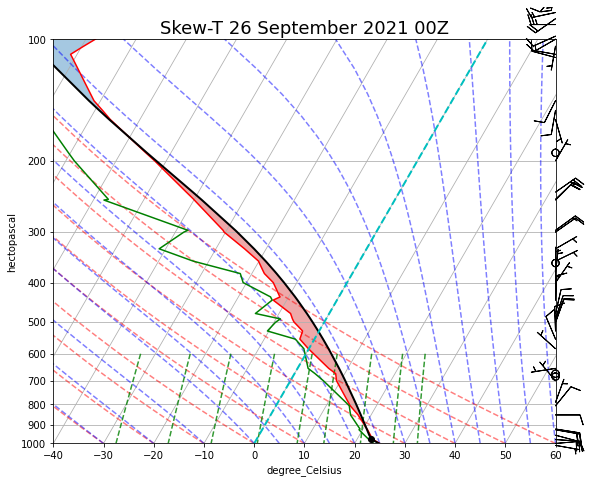

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.title('Skew-T 26 September 2021 00Z', fontsize ='18')
plt.savefig('Juanda.png', dpi=None)
plt.show()

arsiran merah cape, arsiran biru cin.

Adding a Hodograph
------------------

A hodograph is a polar representation of the wind profile measured by the rawinsonde.
Winds at different levels are plotted as vectors with their tails at the origin, the angle
from the vertical axes representing the direction, and the length representing the speed.
The line plotted on the hodograph is a line connecting the tips of these vectors,
which are not drawn.



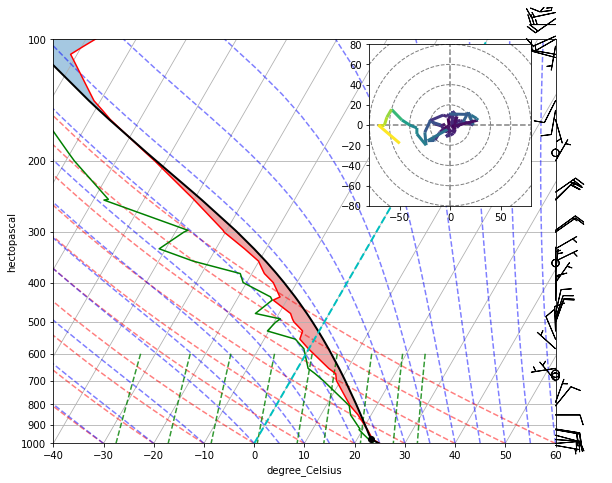

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wind_speed)  # Plot a line colored by wind speed

# Show the plot
plt.savefig('Juanda.png', dpi=None)
plt.show()

# 27 September 2021 00Z

In [ ]:
#Pilih Data yang aka digunakan dalam diagram Skew-T
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']


#Baca Fie data yang tersedia
df = pd.read_fwf('drive/MyDrive/TUBES_MOCU/Radiosonde/27092021_00UTC.txt',skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Menghilangkan Nilai NaN dalam data T,Td, dan Angin
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [ ]:
#Menjadikan data dari contoh dataset ke dalam variabel individu dan menentukan bearannya

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

[teks link](https://)Thermodynamic Calculations
--------------------------

Often times we will want to calculate some thermodynamic parameters of a
sounding. The MetPy calc module has many such calculations already implemented!

* **Lifting Condensation Level (LCL)** - The level at which an air parcel's
  relative humidity becomes 100% when lifted along a dry adiabatic path.
* **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
  at the surface temperature/pressure and rising dry adiabatically until
  reaching the LCL, then rising moist adiabatially.



In [ ]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')


976.1753008901553 hectopascal 22.82091277705439 degree_Celsius


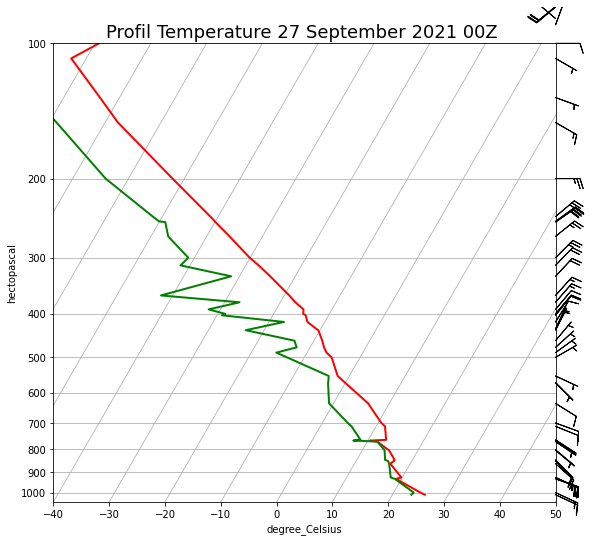

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.title('Profil Temperature 27 September 2021 00Z ', fontsize ='18')
plt.savefig('Juanda1.png', dpi=None)
plt.show()

Plot Skew-T Tambahan
------------------------

Garis fidusia yang menunjukkan adiabat kering, adiabat lembab, dan rasio pencampuran berguna saat melakukan analisis lebih lanjut pada diagram Skew-T. Seringkali isoterm 0C ditekankan dan area CAPE dan CIN diarsir.



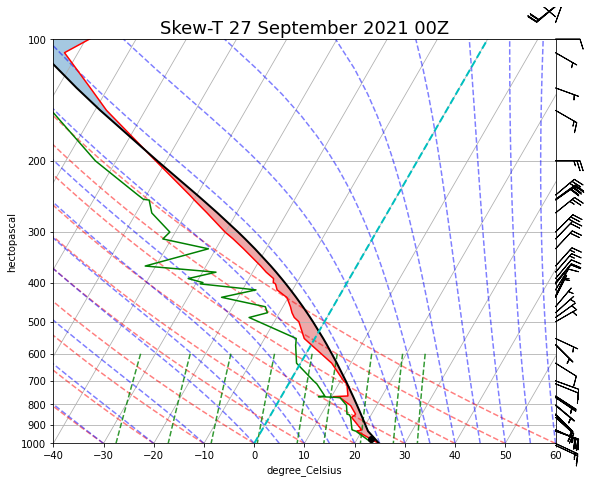

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.title('Skew-T 27 September 2021 00Z', fontsize ='18')
plt.savefig('Juanda.png', dpi=None)
plt.show()

arsiran merah cape, arsiran biru cin.

Adding a Hodograph
------------------

A hodograph is a polar representation of the wind profile measured by the rawinsonde.
Winds at different levels are plotted as vectors with their tails at the origin, the angle
from the vertical axes representing the direction, and the length representing the speed.
The line plotted on the hodograph is a line connecting the tips of these vectors,
which are not drawn.



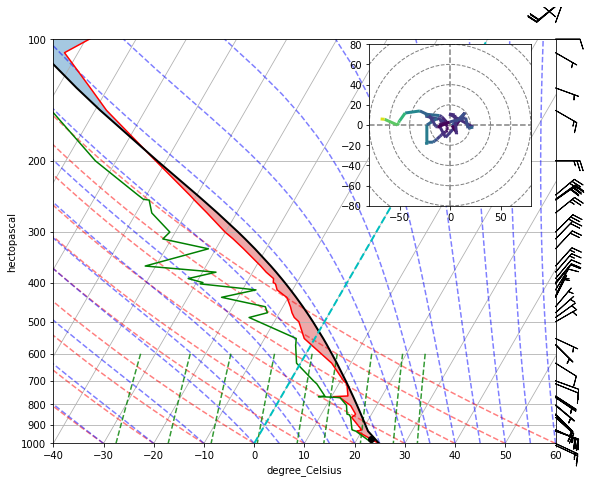

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wind_speed)  # Plot a line colored by wind speed

# Show the plot
plt.savefig('Juanda.png', dpi=None)
plt.show()

# 28 September 2021 00Z

In [ ]:
#Pilih Data yang aka digunakan dalam diagram Skew-T
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']


#Baca Fie data yang tersedia
df = pd.read_fwf('drive/MyDrive/TUBES_MOCU/Radiosonde/28092021_00UTC.txt',skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Menghilangkan Nilai NaN dalam data T,Td, dan Angin
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [ ]:
#Menjadikan data dari contoh dataset ke dalam variabel individu dan menentukan bearannya

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

[teks link](https://)Thermodynamic Calculations
--------------------------

Often times we will want to calculate some thermodynamic parameters of a
sounding. The MetPy calc module has many such calculations already implemented!

* **Lifting Condensation Level (LCL)** - The level at which an air parcel's
  relative humidity becomes 100% when lifted along a dry adiabatic path.
* **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
  at the surface temperature/pressure and rising dry adiabatically until
  reaching the LCL, then rising moist adiabatially.



In [ ]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')


964.3787162652305 hectopascal 21.9085337260413 degree_Celsius


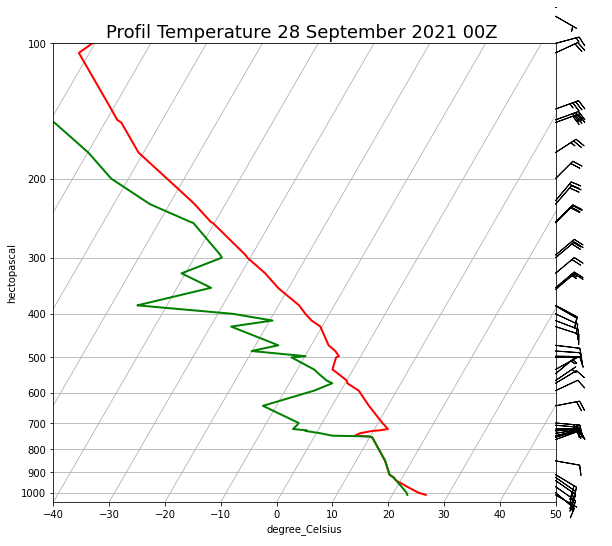

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.title('Profil Temperature 28 September 2021 00Z ', fontsize ='18')
plt.savefig('Juanda1.png', dpi=None)
plt.show()

Plot Skew-T Tambahan
------------------------

Garis fidusia yang menunjukkan adiabat kering, adiabat lembab, dan rasio pencampuran berguna saat melakukan analisis lebih lanjut pada diagram Skew-T. Seringkali isoterm 0C ditekankan dan area CAPE dan CIN diarsir.



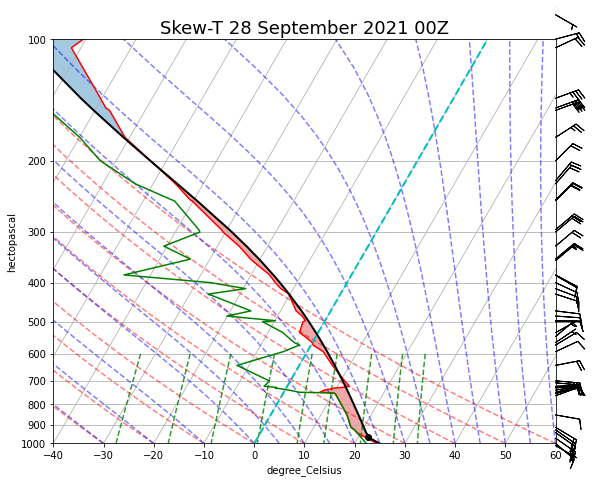

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.title('Skew-T 28 September 2021 00Z', fontsize ='18')
plt.savefig('Juanda.png', dpi=None)
plt.show()

arsiran merah cape, arsiran biru cin.

Adding a Hodograph
------------------

A hodograph is a polar representation of the wind profile measured by the rawinsonde.
Winds at different levels are plotted as vectors with their tails at the origin, the angle
from the vertical axes representing the direction, and the length representing the speed.
The line plotted on the hodograph is a line connecting the tips of these vectors,
which are not drawn.



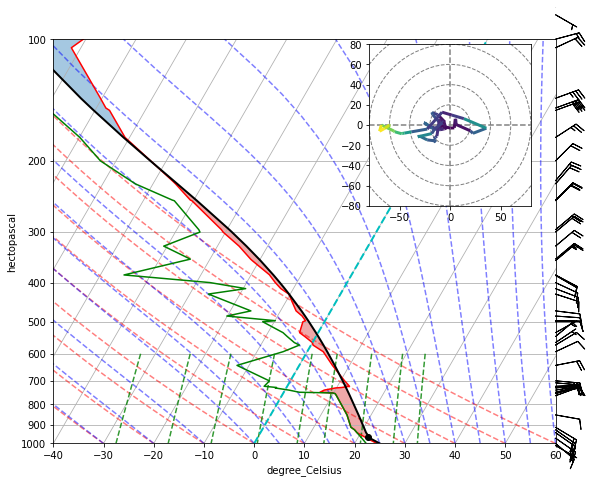

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wind_speed)  # Plot a line colored by wind speed

# Show the plot
plt.savefig('Juanda.png', dpi=None)
plt.show()